In [114]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
import os, datetime
from tensorflow import keras

# by using same seed with your friends, your friends and you will get the same result after computer generated "randomness"
set_seed(455)
np.random.seed(455)

In [115]:
df = pd.read_csv(r'C:\Users\User\Desktop\Capstone1\cases_malaysia.csv',index_col='date',parse_dates=['date'])
df # get overview of the dataset

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,4,4,0,4,0,4,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,3,3,0,7,0,3,0,0,0,1,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-29,146,0,150,8708,0,27,0,29,90,12,...,3,3,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-30,157,1,168,8697,0,27,2,37,91,13,...,7,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,102,1,149,8650,0,24,0,19,59,11,...,3,4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
df.info() # check for the dtype, null value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1744 entries, 2020-01-25 to 2024-11-02
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                1744 non-null   int64  
 1   cases_import             1744 non-null   int64  
 2   cases_recovered          1744 non-null   int64  
 3   cases_active             1744 non-null   int64  
 4   cases_cluster            1744 non-null   int64  
 5   cases_unvax              1744 non-null   int64  
 6   cases_pvax               1744 non-null   int64  
 7   cases_fvax               1744 non-null   int64  
 8   cases_boost              1744 non-null   int64  
 9   cases_child              1744 non-null   int64  
 10  cases_adolescent         1744 non-null   int64  
 11  cases_adult              1744 non-null   int64  
 12  cases_elderly            1744 non-null   int64  
 13  cases_0_4                1744 non-null   int64  
 14  cases_

In [117]:
# remove the NaN and replace it with 0
df['cluster_import'] = df['cluster_import'].fillna(0)
df['cluster_religious'] = df['cluster_religious'].fillna(0)
df['cluster_community'] = df['cluster_community'].fillna(0)
df['cluster_highRisk'] = df['cluster_highRisk'].fillna(0)
df['cluster_education'] = df['cluster_education'].fillna(0)
df['cluster_detentionCentre'] = df['cluster_detentionCentre'].fillna(0)
df['cluster_workplace'] = df['cluster_workplace'].fillna(0)

In [118]:
df.duplicated().sum() # the duplicate is acceptable due to the data, so no need to remove it

np.int64(10)

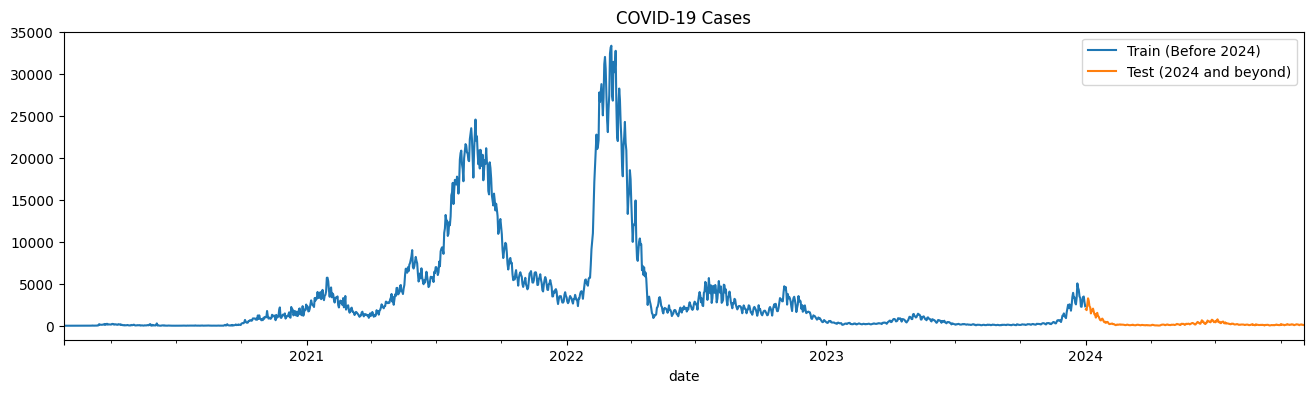

In [119]:
tstart = 2020
tend = 2023

def train_test_plot(df,tstart,tend):
    df.loc[f'{tstart}':f'{tend}','cases_new'].plot(figsize=(16,4),label=f"Train (Before {tend+1})")
    df.loc[f'{tend+1}':, 'cases_new'].plot(figsize=(16,4),label=f"Test ({tend+1} and beyond)")
    plt.legend()
    plt.title('COVID-19 Cases')
    plt.show()

train_test_plot(df,tstart,tend)

In [120]:
# Split the dataset
def train_test_split(df,tstart,tend):
    train = df.loc[f"{tstart}":f"{tend}","cases_new"].values
    test = df.loc[f"{tend+1}":,"cases_new"].values
    return train,test

training_set,test_set = train_test_split(df,tstart,tend)

In [121]:
# Standardize our training data
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled[:5])

[[1.19738969e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.98042268e-05]]


In [122]:
arr = np.array([1,2,3,4,5,6])
print(arr.shape)

print(arr.reshape(3,-1).shape)

(6,)
(3, 2)


In [123]:
def split_sequence(sequence,n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

n_steps = 30
features = 1
# split into samples
X_train,y_train = split_sequence(training_set_scaled,n_steps)

In [124]:
# Reshape X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
print(X_train.shape)

(1407, 30, 1)


In [125]:
# The LSTM Architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=64,activation='tanh',input_shape=(n_steps,features),return_sequences=True))
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(units=32))
model_lstm.add(Dense(units=1))

print(model_lstm.summary())

c:\Users\User\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [126]:
# 8. Compile and fit the model
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
logpath = "tensorboard/Covid-19/" + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
history = model_lstm.fit(X_train,y_train,epochs = 175,batch_size=32, callbacks=[tb])

Epoch 1/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0104 - mae: 0.0558
Epoch 2/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - mae: 0.0232
Epoch 3/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0201
Epoch 4/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0200
Epoch 5/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - mae: 0.0195
Epoch 6/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0193
Epoch 7/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0193
Epoch 8/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0189
Epoch 9/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0190
Epoch 10/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0185
Epoch 11/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0185
Epoch 12/175
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0184
Epoch 13/175
44/44 ━━━━━━

In [127]:
df_total = df.loc[:,'cases_new']
inputs = df_total[len(df_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1,1)
# scaling
inputs = sc.transform(inputs)

# Split into samples
X_test,y_test = split_sequence(inputs,n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],features)
# predictions
predicted_cases = model_lstm.predict(X_test)
# inverse transform the values 
predicted_cases = sc.inverse_transform(predicted_cases)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [128]:
def plot_predictions(test,predicted):
    plt.plot(test,color='gray',label='Real')
    plt.plot(predicted,color='red',label='Predicted')
    plt.title('COVID-19 Cases Prediction')
    plt.xlabel('Day')
    plt.ylabel('COVID-19 Cases')
    plt.legend()
    plt.show()

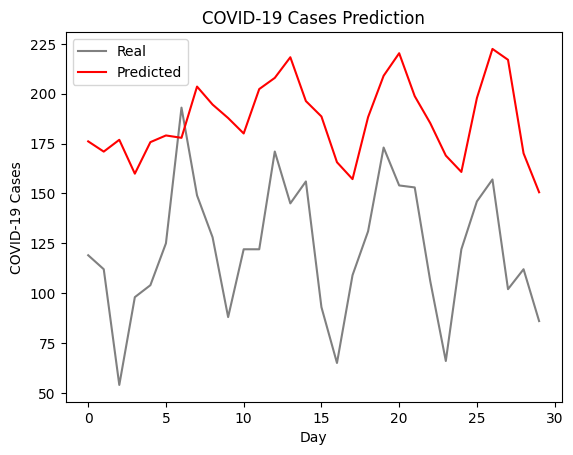

In [129]:
plot_predictions(test_set[-30:],predicted_cases[-30:])

In [130]:
evaluation = model_lstm.evaluate(X_test, y_test)
print(evaluation)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8166e-05 - mae: 0.0036  
[1.4260059288062621e-05, 0.0026806346140801907]


In [131]:
mae = evaluation[1]
print("MAE:", mae)

MAE: 0.0026806346140801907


In [132]:
mape = (mae/sum(abs(y_test))) * 100
print(mape)

[0.09998356]
